# Test notebook for the representation part

# Paper implementation:


### Introduction

**Metadata label generator**
- SVM
- Confusion-matrix
- superclass division based on confusion matrix

**Intelligent reasoning**
- Metadata creation (OvO OvR)
- RandomForest Classifier

Fig. 4 Structure of meta-data classification

In [ ]:
#TODO: Normalize data before every classification (Paper uses Z-Norm)
#TODO: after normalization, divide in two groups which are train and test
# The training process is divided in 
## 1. Representation learning (intelligent reasoning on the paper)
## 2. Feature selection 
## 3. GA-CNN Classifier 

#RESULT: Obtain n models [CNN] (where n is the number of super classes)

### Dataset 

In [71]:
import matplotlib.pyplot as plt
import numpy as np
from src.utils.utils import *
from sklearn import datasets, svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import scipy


#TODO: dataloader of data, normalization and split.

## Extract label and data 
label_path="data/MLinApp_course_data/tcga_mir_label.csv"
data_path="data/MLinApp_course_data/tcga_mir_rpm.csv"

miRna_label, miRna_tissues = extract_label(label_path)
miRna_data = np.genfromtxt(data_path, delimiter=',')[1:,0:-1]

In [72]:
# Deleting all the data that came from TARGET-* labels
number_to_delete = abs(len(miRna_label) - miRna_data.shape[0])
miRna_data = miRna_data[number_to_delete:,:]

In [73]:
# Deleting all the data that came from GBM class use for cycle
# Using only the 29 classes that are in the paper

# not used classes: 'COAD' 'LAML' 'OV' 'GBM'

to_delete = []
for i in range(len(miRna_label)):
    if miRna_label[i] == 'GBM' or miRna_label[i] == 'COAD' or miRna_label[i] == 'LAML' or miRna_label[i] == 'OV':
        to_delete.append(i)

#Remove GBM data from miRna_data and miRna_label
miRna_data = np.delete(miRna_data, to_delete, axis=0)
miRna_label = np.delete(miRna_label, to_delete, axis=0)
miRna_tissues = np.delete(miRna_tissues, to_delete, axis=0)

#Balance BRCA data
index_BRCA = []
for i in range(len(miRna_label)):
    if miRna_label[i] == 'BRCA':
        index_BRCA.append(i)

index_BRCA = np.random.choice(index_BRCA, 600, replace=False)
miRna_data = np.delete(miRna_data, index_BRCA, axis=0)
miRna_label = np.delete(miRna_label, index_BRCA, axis=0)
miRna_tissues = np.delete(miRna_tissues, index_BRCA, axis=0)

In [74]:
## Labeling process: removing the duplicates
label_idx, dictionary = label_processing(miRna_label)
labels = np.unique(miRna_label, return_counts=True)
tissues = np.unique(miRna_tissues)

lab = []
for i in range(len(labels[0])):
  lab.append((labels[0][i], labels[1][i], dictionary[labels[0][i]]))

lab.sort(key= lambda x: x[1])

print(labels[0])
print(tissues)

['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'DLBC' 'ESCA' 'HNSC' 'KICH' 'KIRC'
 'KIRP' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'PAAD' 'PCPG' 'PRAD' 'READ'
 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC' 'UCS' 'UVM']
['Adrenal gland' 'Base of tongue' 'Bladder'
 'Bones, joints and articular cartilage of limbs'
 'Bones, joints and articular cartilage of other and unspecified sites'
 'Brain' 'Breast' 'Bronchus and lung' 'Cervix uteri' 'Colon'
 'Connective, subcutaneous and other soft tissues' 'Corpus uteri'
 'Esophagus' 'Eye and adnexa' 'Floor of mouth' 'Gallbladder' 'Gum'
 'Heart, mediastinum, and pleura' 'Hypopharynx' 'Kidney' 'Larynx' 'Lip'
 'Liver and intrahepatic bile ducts' 'Lymph nodes' 'Meninges' 'Oropharynx'
 'Other and ill-defined sites'
 'Other and ill-defined sites in lip, oral cavity and pharynx'
 'Other and unspecified major salivary glands'
 'Other and unspecified male genital organs'
 'Other and unspecified parts of biliary tract'
 'Other and unspecified parts of mouth'
 'Other and unsp

In [75]:
print(lab)
print(len(tissues))

[('CHOL', 45, 4), ('DLBC', 47, 5), ('UCS', 57, 27), ('ACC', 80, 0), ('UVM', 80, 28), ('MESO', 87, 15), ('KICH', 91, 8), ('THYM', 126, 25), ('TGCT', 156, 23), ('READ', 165, 19), ('PAAD', 183, 16), ('PCPG', 187, 17), ('ESCA', 200, 6), ('SARC', 263, 20), ('CESC', 312, 3), ('KIRP', 326, 10), ('LIHC', 425, 12), ('BLCA', 437, 1), ('SKCM', 452, 21), ('STAD', 491, 22), ('LUSC', 523, 14), ('LGG', 530, 11), ('PRAD', 551, 18), ('LUAD', 567, 13), ('HNSC', 569, 7), ('THCA', 573, 24), ('UCEC', 579, 26), ('BRCA', 607, 2), ('KIRC', 616, 9)]
52


In [76]:
# Z-score normalization
miRna_data = scipy.stats.zscore(miRna_data, axis=1)
assert np.isnan(miRna_data).sum() == 0

In [77]:
# Splitting dataset in train and test using 60% train and 20% validation 20%evaluation
train_data, val_data, train_label, val_label = train_test_split(miRna_data, miRna_label, test_size=0.20, random_state=42)
#train_data, eva_data, train_label, eva_label = train_test_split(train_data, train_label, test_size=0.25, random_state=42)

In [78]:
n_classes = np.unique(train_label).size

print(n_classes)

29


In [79]:
print("Training set dimensions: {}".format(train_data.shape))
print("Validation set dimensions: {}".format(val_data.shape))
#print("Test set dimensions: {}".format(eva_data.shape))

print("\n")

print("Dimensions of a single sample: {}".format(train_data[0].shape))

Training set dimensions: (7460, 1881)
Validation set dimensions: (1865, 1881)


Dimensions of a single sample: (1881,)


### Tuning SVM for first classification

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#TODO: #3 SVM prior-classification and superclass identification confusion matrix based.
#classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

random_grid_svm = {'kernel': ['rbf', 'poly', 'sigmoid'],
                   'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1],
                   'degree': [2,3,4,5],
                   'class_weight': [None, 'balanced'],
                   'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]}

In [ ]:
search = RandomizedSearchCV(estimator=svm.SVC(),
                            param_distributions= random_grid_svm,
                            scoring='balanced_accuracy',
                            n_iter=10,
                            cv=5,
                            verbose=1,
                            random_state=42,
                            n_jobs=-1)

In [ ]:
search.fit(train_data, train_label)
classifier = search.best_estimator_

### Model selection and confusion matrix

Best params:

`{'kernel': 'poly',
 'gamma': 0.001,
 'degree': 4,
 'class_weight': 'balanced',
 'C': 20}`

In [105]:
#model = svm.SVC(C=20, kernel='poly', gamma=0.001, degree=4, class_weight= 'balanced')
model = svm.SVC(C=20, kernel='rbf', gamma=0.001, degree=4, class_weight= 'balanced')



In [81]:
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sns
from typing import Tuple
from sklearn.metrics import confusion_matrix

def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes]) 

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba, model_

In [82]:
def lab2int(labels):
    lab = []
    for l in labels:
        lab.append(dictionary[l])
    return lab

In [83]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=lab2int(sorted_labels))
    
    plt.figure(figsize=(20,20))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()

In [106]:
# Re-Training of the optimal model through cross validation, this is made to take the predictions.
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
actual_classes, predicted_classes, _ , classifier = cross_val_predict(model, kfold, train_data, np.array(lab2int(train_label)))

In [85]:
lab2int(labels[0])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28]

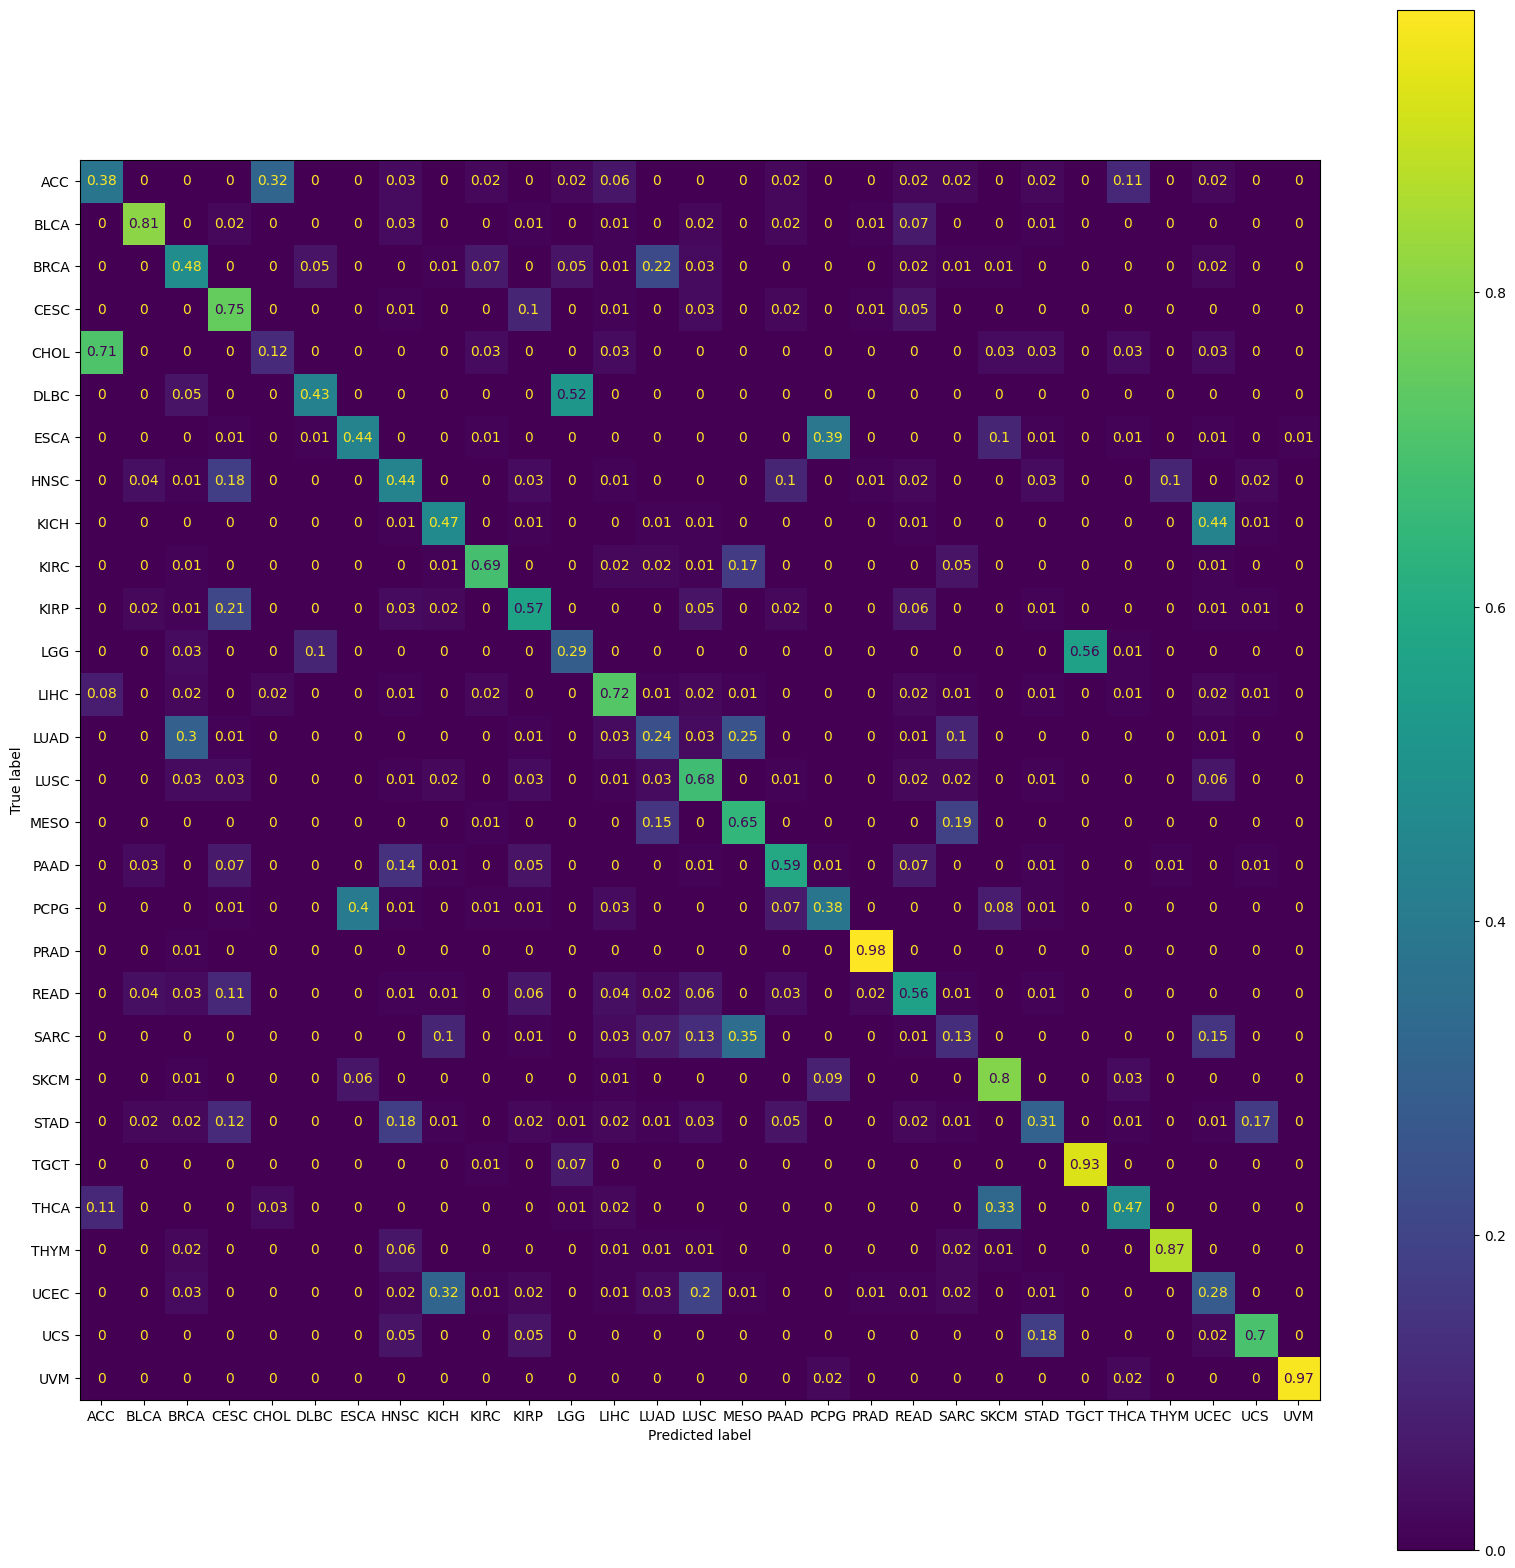

In [107]:
#Plotting confusion matrix. For the selection of superclass, use "cm".
from sklearn.metrics import confusion_matrix
import itertools
np.set_printoptions(precision=2)
cm = confusion_matrix(actual_classes, predicted_classes,normalize='true')
cmp = ConfusionMatrixDisplay(cm, display_labels=labels[0])
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        cm[i,j] = format(cm[i, j], '.2f')
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax)


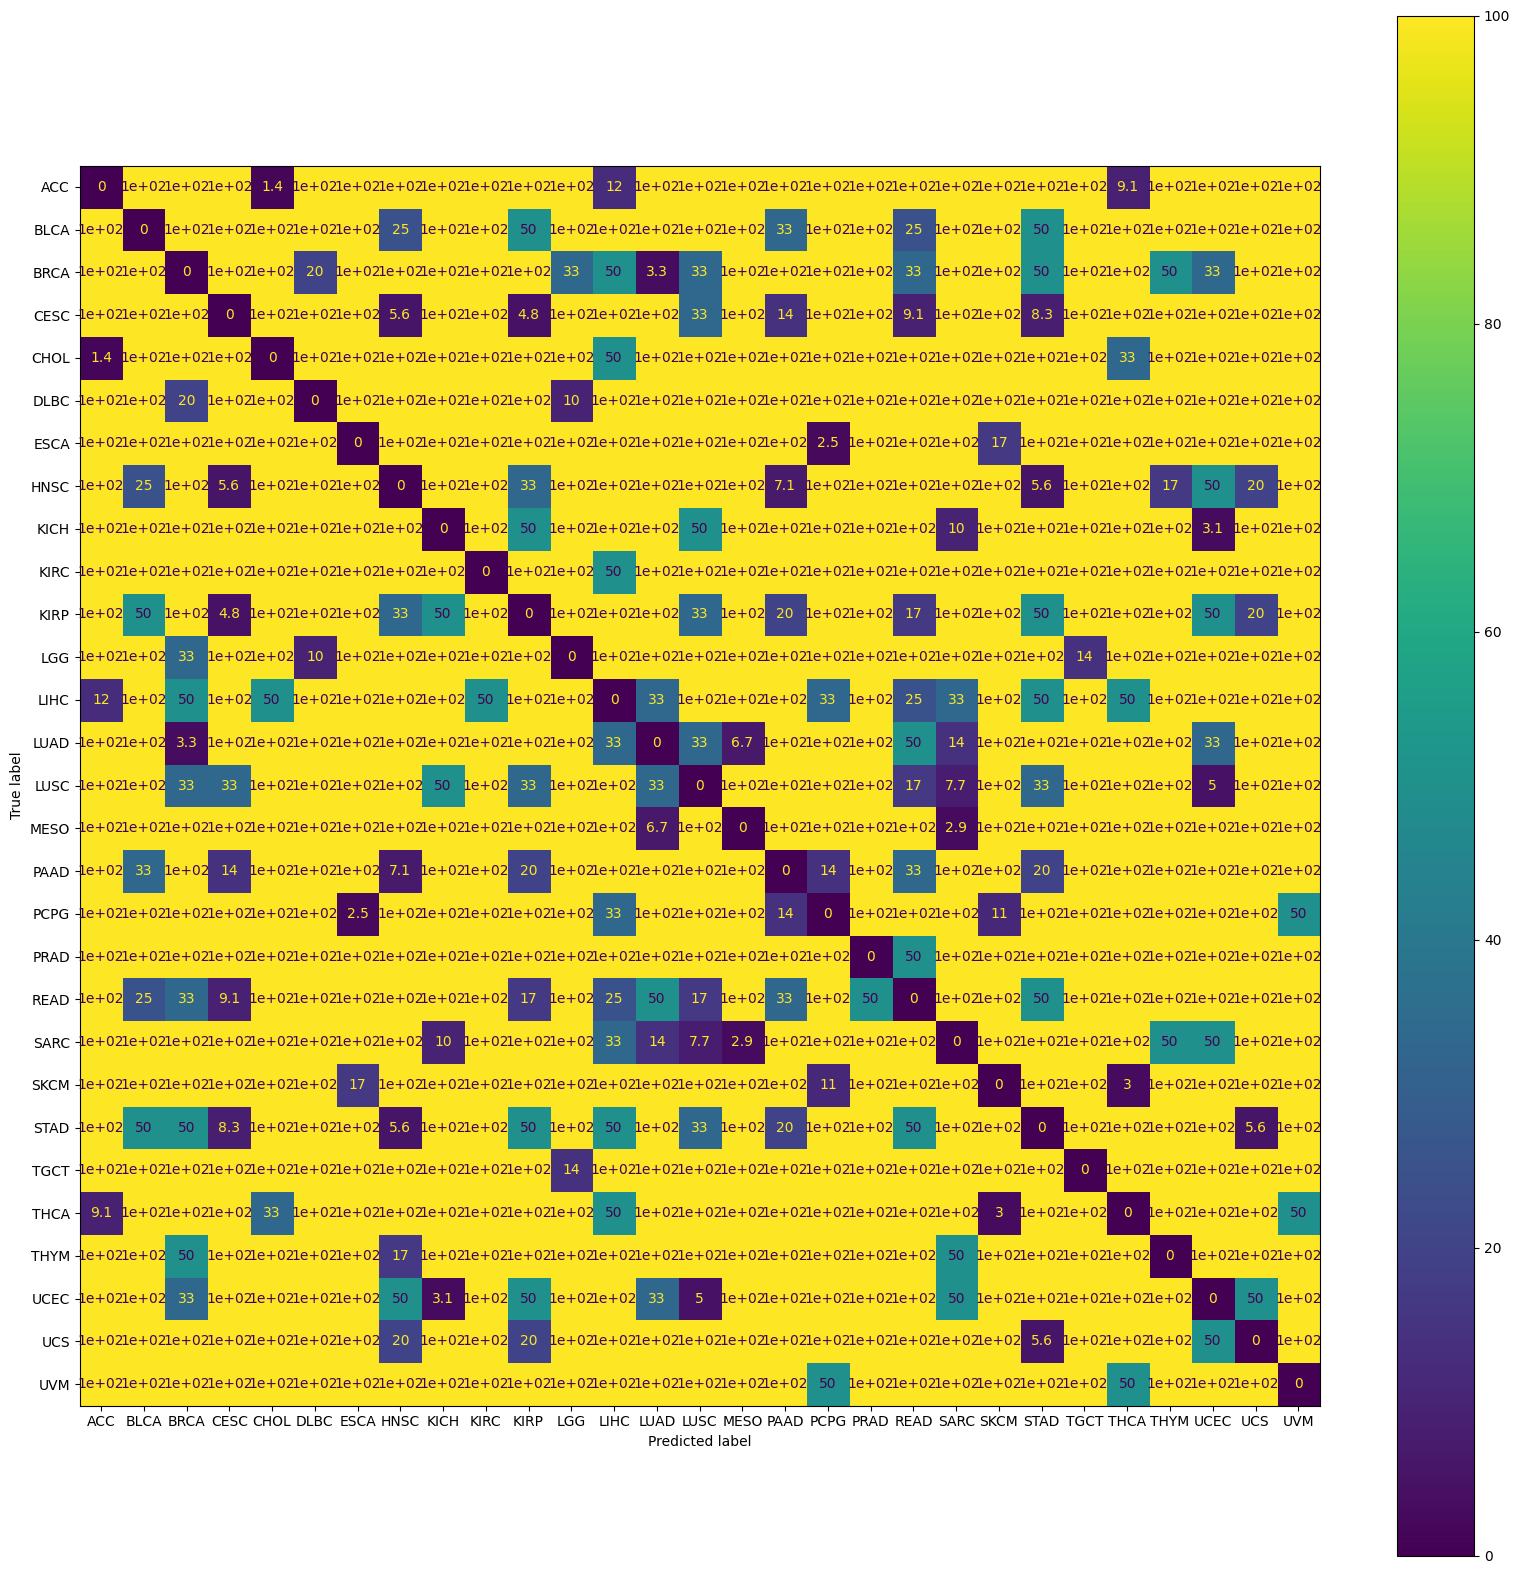

In [181]:
#Convert the confusion matrix into a metric matrix (superclass identification)
metric_matrix = np.zeros((n_classes,n_classes))

for i in range(n_classes):
    for j in range(n_classes):
        if i == j:
            metric_matrix[i,j] = 0 #cm[i,j]
        else:
            metric_matrix[i,j] = 1/cm[i,j] if cm[i,j] != 0 else 100 #cm[i,j] + cm[j,i]
#make it simetric
for i in range(n_classes):
    for j in range(n_classes):
        if i != j:
            metric_matrix[i,j] = metric_matrix[j,i]




#Plotting the metric matrix
cmp = ConfusionMatrixDisplay(metric_matrix, display_labels=labels[0])
for i, j in itertools.product(range(metric_matrix.shape[0]), range(metric_matrix.shape[1])):
        metric_matrix[i,j] = format(metric_matrix[i, j], '.2f')
fig, ax = plt.subplots(figsize=(20,20))
cmp.plot(ax=ax)



C:\Users\fra_s\AppData\Local\Temp\ipykernel_13708\2402041521.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = shc.linkage(metric_matrix,


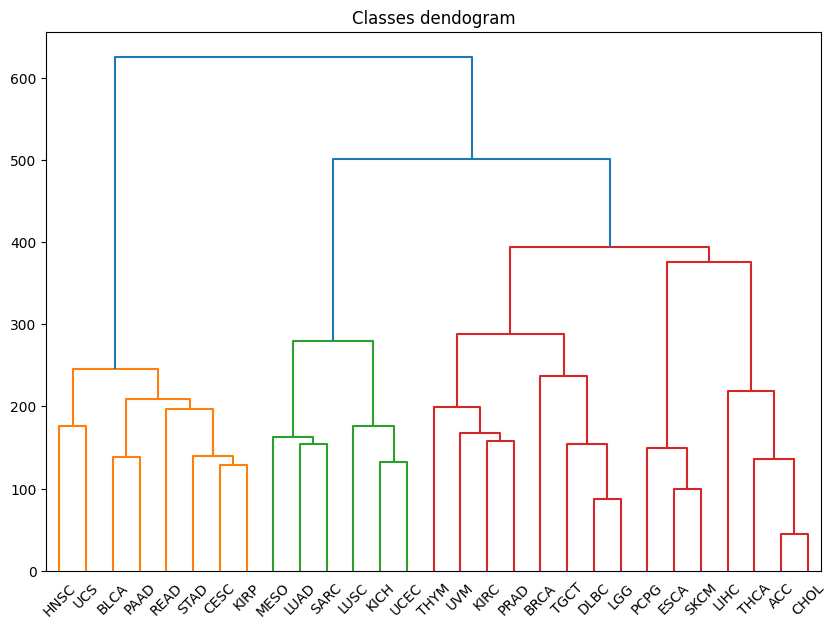

In [182]:
#We know that i is the class to predict and j is the predicted class. So cm[i][j] is the miss-classification ratio 
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Classes dendogram")

# Plotting dendogram

clusters = shc.linkage(metric_matrix, 
            method='ward')
shc.dendrogram(Z=clusters, labels=labels[0])
plt.show()

### Clustering Gerarchico (Ward + Euclidean distance) per superclass identification.

In [183]:
# Grouping classes in 5 superclasses minimizing the inter-class overlap

from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=5, linkage='ward',metric='euclidean')
clustering_model.fit(metric_matrix)
clustering_model.labels_


d:\miRNA Project\cancer_miRNA_classification_with_spiking_neural_network\.venv\lib\site-packages\scipy\cluster\hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([3, 1, 0, 1, 3, 0, 4, 1, 2, 0, 1, 0, 3, 2, 2, 2, 1, 4, 0, 1, 2, 4,
       1, 0, 3, 0, 2, 1, 0], dtype=int64)

In [185]:
#Labels = labels[0] (ordered)
#c_per_l = cluster per label
c_per_l = clustering_model.labels_
superclasses = {'0': [], '1': [], '2': [], '3': [], '4': []} #, '5': [], '6': [], '7': [] }
for i in range(len(labels[0])):
    superclasses[str(c_per_l[i])].append(labels[0][i])
for key in superclasses.keys():
    print(len(superclasses[key]))
    print(superclasses[key])

8
['BRCA', 'DLBC', 'KIRC', 'LGG', 'PRAD', 'TGCT', 'THYM', 'UVM']
8
['BLCA', 'CESC', 'HNSC', 'KIRP', 'PAAD', 'READ', 'STAD', 'UCS']
6
['KICH', 'LUAD', 'LUSC', 'MESO', 'SARC', 'UCEC']
4
['ACC', 'CHOL', 'LIHC', 'THCA']
3
['ESCA', 'PCPG', 'SKCM']


### Other types of clustering for superclass identification without confusion matrix

In [ ]:
#TODO: #4 Superclass division
## divide, ma con duplicati dentro le superclassi, da capire se è normale o meno
#train data -> miRna_data
#train label -> miRna_label

from sklearn.cluster import KMeans #divide in clusters
from sklearn.metrics import silhouette_score #calculate index of silhouette for the quality of the cluster

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 5 #superclass 0...4
label_superclasses,data_superclasses=[],[]

#Kmeans
kmeans = KMeans(n_clusters=numberOfSuperclass, random_state=0)
cluster_labels = kmeans.fit_predict(miRna_data_sc)

#silhouette
silhouette_avg = silhouette_score(miRna_data_sc, cluster_labels)
#print(f"Silhouette Score: {silhouette_avg}")

#
data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

#filling superclasses DUPLICATI
for i, cluster_label in enumerate(cluster_labels):
   data_superclasses[cluster_label].append(miRna_data_sc[i])
   label_superclasses[cluster_label].append(miRna_label_sc[i])

# TESTING TO REMOVE DUPLICATES - NOT YET WORKING
# for i, cluster_label in enumerate(cluster_labels):
#     data_superclasses[cluster_label].append(miRna_data_sc[i])
#     if miRna_label_sc[i] not in label_superclasses[cluster_label]:
#         label_superclasses[cluster_label].append(miRna_label_sc[i])

#results
for i in range(numberOfSuperclass):
    print("\nSuperclass: ",i)
    print(f"\nNumber of classes: {len(np.unique(label_superclasses[i]))}")
    for label in np.unique(label_superclasses[i]):
        elements=0
        for j in label_superclasses[i]:
            #print("val j: ",j)
            if j==label:
                elements=elements+1
                #print("qui dentro")
        print(f"\t{label}={elements}")

In [ ]:
#TODO: 4 --- kmeans + no duplicates between superclasses
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 5  # Superclass 0...4
label_superclasses, data_superclasses = [], []

#kmeans
kmeans = KMeans(n_clusters=numberOfSuperclass, random_state=0)
cluster_labels = kmeans.fit_predict(miRna_data_sc)

data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

#to track the assigned labels and their count
assigned_labels = {i: defaultdict(int) for i in range(numberOfSuperclass)}

#filling superclasses and assigned labels -> actually counting
for i, cluster_label in enumerate(cluster_labels):
    data_point = miRna_data_sc[i]
    label = miRna_label_sc[i]

    #check if the label is in the current superclass
    if label in assigned_labels[cluster_label]:
        assigned_labels[cluster_label][label] += 1
    else:
        assigned_labels[cluster_label][label] = 1

    #check if its in any else
    assigned_to_other_superclass = False
    for other_superclass in range(numberOfSuperclass):
        if other_superclass != cluster_label and label in assigned_labels[other_superclass]:
            assigned_to_other_superclass = True
            break

    if not assigned_to_other_superclass:
        #no superclasses
        data_superclasses[cluster_label].append(data_point)
        label_superclasses[cluster_label].append(label)

#result
for i in range(numberOfSuperclass):
    print("\nSuperclass: ", i)
    print(f"\nNumber of classes: {len(np.unique(label_superclasses[i]))}")
    
    #keeping only the max
    max_label = max(assigned_labels[i], key=assigned_labels[i].get)
    
    for label in np.unique(label_superclasses[i]):
        elements = assigned_labels[i][label]
        print(f"\t{label}={elements}")


In [ ]:
#TODO: #4 tsne
from sklearn.manifold import TSNE
import numpy as np
from collections import defaultdict

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 2  # Superclass 0...4 #se metto 5 va in errore perché il tsne è bidim
label_superclasses, data_superclasses = [], []

#t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=0)
tsne_result = tsne.fit_transform(miRna_data_sc)

# tsne to divide -> stackoverflow
x_min, x_max = np.min(tsne_result, 0), np.max(tsne_result, 0)
X_norm = (tsne_result - x_min) / (x_max - x_min)
superclass_assignment = np.argmin(X_norm, axis=1)

data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

#counting assigned labels 
assigned_labels = {i: defaultdict(int) for i in range(numberOfSuperclass)}

#filling superclasses
for i, cluster_label in enumerate(superclass_assignment):
    data_point = miRna_data_sc[i]
    label = miRna_label_sc[i]

    #removing duplicates if any in the superclass, and counting the number of elements
    if label in assigned_labels[cluster_label]:
        assigned_labels[cluster_label][label] += 1
    else:
        assigned_labels[cluster_label][label] = 1

    #check if assigned to any other superclass
    assigned_to_other_superclass = False
    for other_superclass in range(numberOfSuperclass):
        if other_superclass != cluster_label and label in assigned_labels[other_superclass]:
            assigned_to_other_superclass = True
            break

    if not assigned_to_other_superclass:
        #not assigned in any
        data_superclasses[cluster_label].append(data_point)
        label_superclasses[cluster_label].append(label)

#result
for i in range(numberOfSuperclass):
    print("\nSuperclass: ", i)
    print(f"\nNumero di classi: {len(np.unique(label_superclasses[i]))}")

    #removing outliers 
    max_label = max(assigned_labels[i], key=assigned_labels[i].get)

    for label in np.unique(label_superclasses[i]):
        elements = assigned_labels[i][label]
        print(f"\t{label}={elements}")


 PCA + kmeans (two steps)

In [ ]:
#TODO: #4 -> PCA + Kmeans
#Part 1
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
print("getting the best number of components")
miRna_data_sc = train_data
miRna_label_sc = train_label
# Fit PCA with a range of components
n_components_range = range(1, 21)  
explained_variances = []

for n in n_components_range:
    pca = PCA(n_components=n)
    pca.fit(miRna_data_sc)
    explained_variances.append(np.sum(pca.explained_variance_ratio_))

# Plot the explained variances
plt.plot(n_components_range, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow graph')
plt.grid()
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from collections import defaultdict

miRna_data_sc = train_data
miRna_label_sc = train_label
numberOfSuperclass = 5  # Superclass 0...4
label_superclasses, data_superclasses = [], []

# PCA
n_components = 13  #10-15
pca = PCA(n_components=n_components)
miRna_data_pca = pca.fit_transform(miRna_data_sc)

# K-Means
kmeans = KMeans(n_clusters=numberOfSuperclass, random_state=0)
cluster_labels = kmeans.fit_predict(miRna_data_pca)

data_superclasses = [[] for _ in range(numberOfSuperclass)]
label_superclasses = [[] for _ in range(numberOfSuperclass)]

# To track the assigned labels and their count
assigned_labels = {i: defaultdict(int) for i in range(numberOfSuperclass)}

# Filling superclasses and assigned labels -> actually counting
for i, cluster_label in enumerate(cluster_labels):
    data_point = miRna_data_sc[i]
    label = miRna_label_sc[i]

    # Check if the label is in the current superclass
    if label in assigned_labels[cluster_label]:
        assigned_labels[cluster_label][label] += 1
    else:
        assigned_labels[cluster_label][label] = 1

    # Check if it's in any else
    assigned_to_other_superclass = False
    for other_superclass in range(numberOfSuperclass):
        if other_superclass != cluster_label and label in assigned_labels[other_superclass]:
            assigned_to_other_superclass = True
            break

    if not assigned_to_other_superclass:
        # No superclasses
        data_superclasses[cluster_label].append(data_point)
        label_superclasses[cluster_label].append(label)
        
print("\nNumber of components: ",n_components)
# Result
for i in range(numberOfSuperclass):
    print("\nSuperclass: ", i)
    print(f"\nNumber of classes: {len(np.unique(label_superclasses[i]))}")

    # Keeping only the max
    max_label = max(assigned_labels[i], key=assigned_labels[i].get)

    for label in np.unique(label_superclasses[i]):
        elements = assigned_labels[i][label]
        print(f"\t{label}={elements}")


## Intelligent reasoning

### Metada generation

In [186]:
#TODO: #5 Metadata creation (OvO - One v One + OvR - One v Rest) + Random Forest classification
#In the paper they use GradientBoosting for metadata creation
from sklearn.ensemble import GradientBoostingClassifier as gb
from sklearn.multiclass import OneVsRestClassifier as ovr, OneVsOneClassifier as ovo 
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sns
from typing import Tuple
import pickle as pkl
from sklearn.metrics import confusion_matrix

In [196]:
#CROSS VALIDATION FOR METADATA CREATION, WE USE CV TO CREATE THE METADATA ON THE TRAINING SET WITHOUT BIASING IT.
#1. OVO AND OVR ARE TRAINED
#2. THE MODELS OF OVO AND OVR MAKES PREDICTIONS ON THE DATA
#3. THE PREDICTIONS ARE TAKEN AS METADATA
#4. ALL THE DATA ARE STACKED TOGETHER AS A METADATA MATRIX.

def meta_data_creation_train(ovo, ovr, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    ovo_ = cp.deepcopy(ovo)
    ovr_ = cp.deepcopy(ovr)
    actual_classes = np.empty([0], dtype=int)
    ovo_m = []
    ovr_m = []
    print("Starting k-fold cross validation...\n")
    n = 0
    for train_ndx, test_ndx in kfold.split(X):
        scores_ovo = []
        scores_ovr = []
        print("Fold {}".format(n+1))
        n = n+1
        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)
        #train
        ovo_.fit(train_X, train_y)
        print("ovo done")
        ovr_.fit(train_X, train_y)
        print("ovr done")
        
        models_ovo = list(ovo_.estimators_)
        models_ovr = list(ovr_.estimators_)

        for mod in models_ovo:
            scores_ovo.append(mod.predict(test_X))
        for mod in models_ovr:
            scores_ovr.append(mod.predict(test_X))
        if n == 1:
            ovo_m = np.array(scores_ovo).T
            ovr_m = np.array(scores_ovr).T
        else:
            ovo_m = np.vstack([ovo_m, np.array(scores_ovo).T])
            ovr_m = np.vstack([ovr_m, np.array(scores_ovr).T])
        print("Metadata for {}° split created".format(n))
    meta_data = np.hstack([ovo_m, ovr_m])
    print("Metadata for the whole dataset created!")
    return meta_data, actual_classes, ovo_, ovr_

def save_metadata(metadata, metalabel):
    print("Saving metadata...")
    with open("data/metadata/metadata_train.pkl", "wb") as f:
        pkl.dump(metadata, f)

    with open("data/metadata/metalabel_train.pkl", "wb") as f:
        pkl.dump(metalabel, f)

    print("Complete!")

def load_metadata():
    metadata = []
    metalabel = []
    with open("data/metadata/metadata_train.pkl", "rb") as f:
        metadata = pkl.load(f)

    with open("data/metadata/metalabel_train.pkl", "rb") as f:
        metalabel = pkl.load(f)

    return metadata, metalabel


In [209]:
#inizializing models

ovo_model = ovo(svm.SVC(C=20, class_weight='balanced', gamma=0.001), n_jobs=-1) #One vs One with GradientBoostingClassifier
ovr_model = ovr(svm.SVC(C=20, class_weight='balanced', gamma=0.001), n_jobs=-1) #One vs Rest with GradientBoostingClassifier

rf_model = RandomForestClassifier()

In [210]:
#Replacing label with superclass labels.

train_super_label = train_label
for k,v in superclasses.items():
    for a in v:
        train_super_label = list(map(lambda x: x.replace(a, k), train_super_label))
train_super_label = [int(x) for x in train_super_label]

In [211]:
#meta_data creation of training set through cross_validation.
#TODO: Dobbiamo stackare la metalabel alla fine?
#TODO: TRAINARE E GENERARE META-LABEL 
import pickle as pkl
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
meta_data, meta_label, t_ovo, t_ovr = meta_data_creation_train(ovo_model, ovr_model, kfold, train_data, np.array(train_super_label))

save_metadata(meta_data, meta_label)

Starting k-fold cross validation...

Fold 1
ovo done
ovr done
Metadata for 1° split created
Fold 2
ovo done
ovr done
Metadata for 2° split created
Fold 3
ovo done
ovr done
Metadata for 3° split created
Fold 4
ovo done
ovr done
Metadata for 4° split created
Fold 5
ovo done
ovr done
Metadata for 5° split created
Metadata for the whole dataset created!
Saving metadata...
Complete!


In [219]:
print("Training metadata dimensions: {}".format(meta_data.shape))
#print("Test set dimensions: {}".format(eva_data.shape))
print("\n")

print("Dimensions of a single sample: {}".format(meta_data[0].shape))


Training metadata dimensions: (7460, 15)


Dimensions of a single sample: (15,)


In [ ]:
# This part of code was made bacause the first time we used the meta_data creation we stacked the wrong way, so the sample were stacked horizontally with shape (1773,75)
# but the models (ovo+ovr) are 15, so we reshape the data to have (training_sample, ovo+ovr models) = (8865,15)
# BE AWARE that the code now should be fixed, so check always the training metadata dimension (cell above) before running this cell.

offset1 = 10
offset2 = 5
index = 0
ovo_m = []
ovr_m = []
for i in range(5):
    ovo1 = meta_data[:,index:index+offset1]
    index = index + offset1
    ovr1 = meta_data[:,index:index+offset2]
    index = index + offset2
    if i == 0:
        ovo_m = ovo1
        ovr_m = ovr1
    else:
        ovo_m = np.vstack([ovo_m, ovo1])
        ovr_m = np.vstack([ovr_m, ovr1])
new_metadata = np.hstack([ovo_m, ovr_m])
new_metadata.shape
        


In [213]:
#As above, before running this cell check the dimensions
save_metadata(meta_data, meta_label)

Saving metadata...
Complete!


In [214]:
#This cell exists only to check if metadata are correctly loaded after saving.
metadata, metalabel = load_metadata()
print(metadata.shape)
print(metadata[0].shape)
print(metalabel.shape)

(7460, 15)
(15,)
(7460,)


### Meta-data Classification with RandomForest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {'n_estimators': [20,50,100,200],
              'max_depth': [2,5,10,20,50,]}

# Create a random forest classifier
rf = RandomForestClassifier(class_weight="balanced_subsample")

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5)

rand_search.fit(metadata, metalabel)
best = rand_search.best_estimator_

In [205]:
best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [216]:

rf_model = RandomForestClassifier(n_estimators=500, class_weight="balanced_subsample", n_jobs=-1)

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
act_y, pred_y, pred_prob, a = cross_val_predict(rf_model, kfold, metadata, metalabel)


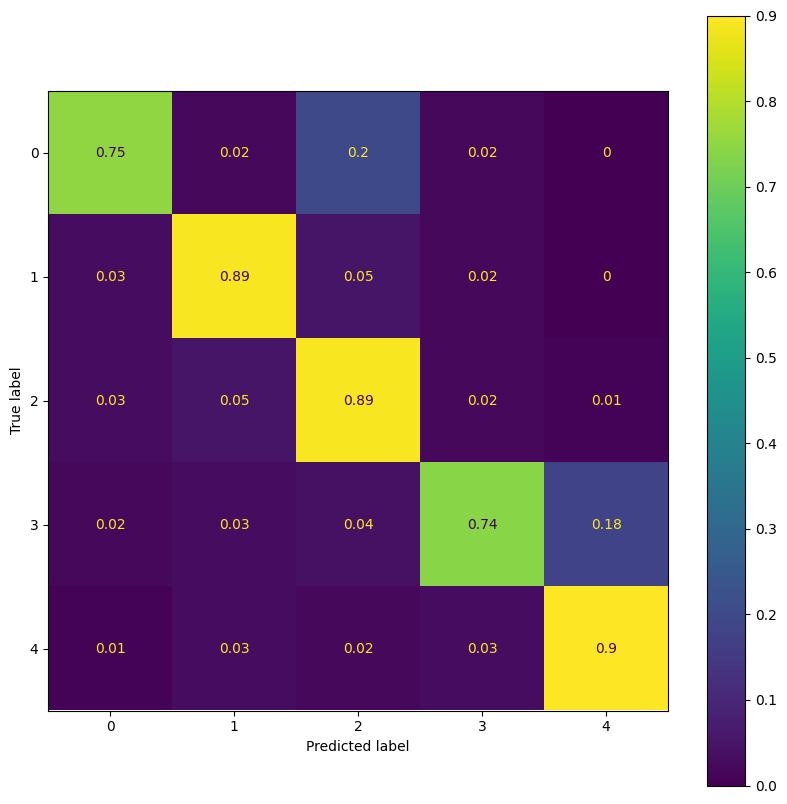

In [217]:
#Plotting confusion matrix. For the selection of superclass, use "cm".
from sklearn.metrics import confusion_matrix
import itertools
np.set_printoptions(precision=2)
cm_meta = confusion_matrix(act_y, pred_y, normalize='true')
cmp = ConfusionMatrixDisplay(cm_meta, display_labels=range(5))
for i, j in itertools.product(range(cm_meta.shape[0]), range(cm_meta.shape[1])):
        cm_meta[i,j] = format(cm_meta[i, j], '.2f')
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

In [218]:
from sklearn.metrics import accuracy_score

accuracy_score(act_y, pred_y)

0.8329758713136729